In [1]:
import pandas as pd
import seaborn as sns

In [2]:
model_file_path = "../data/Agroforestry Biomass Modeling outputs.xlsx"
model_excel_file = pd.ExcelFile(model_file_path)
study_names = model_excel_file.sheet_names
author_names = [x.replace(" Mg Cha","") + "" for x in study_names]

empirical_file_path = "../data/notes.xlsx"
emp_excel_file = pd.ExcelFile(empirical_file_path)
emp_sheet_names = emp_excel_file.sheet_names
emp_df = pd.read_excel(empirical_file_path, sheet_name='empirical_simple')


In [3]:
# setup out list to store results
results_list = []

# loop thru studies in the modeling outputs excel sheet names
for name in author_names:
    
    # find the empirical data in notes spreadsheet 
    if (len(emp_df[emp_df['source'] == name]))>0:
        print(name + "-----------" * 5)
        edf = emp_df[emp_df['source'] == name]
        mdf = pd.read_excel(model_file_path, sheet_name=f'{name} Mg Cha')
        
        # get the nyears and mt c
        nyears = edf['Age #1'].values[0]
        mgco2 = edf['Mg-C-ha'].values[0]
        
        # filter 
        time_df = mdf[mdf['t'] == nyears]
        time_df.loc[:,'empirical'] = mgco2
        
        # calc errors and compile 
        error_dict = {}
        model_names = [x for x in time_df.columns if not x in ['t', 'empirical']]
        for i in model_names:
            # absolute erorr
#             error_dict[i+"_raw"] = time_df[i].values[0]
#             error_dict[i+"_emp"] = time_df['empirical'].values[0]
            error_dict[i + "_abs"] = [time_df[i].values[0] - time_df['empirical'].values[0]]
            # absolute erorr
            error_dict[i + "_pct"] = [(time_df[i].values[0] - time_df['empirical'].values[0]) / time_df['empirical'].values[0] * 100] 
            
        error_df = pd.DataFrame.from_dict(error_dict)
        error_df['study'] = name
        error_df['true_val'] = mgco2
        error_df['nyears'] = nyears
        results_list.append(error_df)

Sharrow-------------------------------------------------------
Thomas_FV-------------------------------------------------------
Orefice_A-------------------------------------------------------
Orefice_B-------------------------------------------------------
Adewopo-------------------------------------------------------


/var/folders/py/9t078qzs52x65tkpvg23_4mc0000gn/T/ipykernel_28723/1497266557.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df.loc[:,'empirical'] = mgco2
/var/folders/py/9t078qzs52x65tkpvg23_4mc0000gn/T/ipykernel_28723/1497266557.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df.loc[:,'empirical'] = mgco2
/var/folders/py/9t078qzs52x65tkpvg23_4mc0000gn/T/ipykernel_28723/1497266557.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [4]:
# pd.concat(results_list).count()

In [5]:
# compile pct results
rdf_pct = pd.concat(results_list)[['COMET_pct', 'iTree Planting FS_pct',
                               'iTree Planting PS_pct', 'FVS_pct', 'iTree Eco_pct','study','nyears']]

# compile abs results
rdf_abs = pd.concat(results_list)[['COMET_abs', 'iTree Planting FS_abs',
                               'iTree Planting PS_abs', 'FVS_abs', 'iTree Eco_abs','study']]

# save 
rdf_pct.to_csv("../results/rdf_pct.csv")

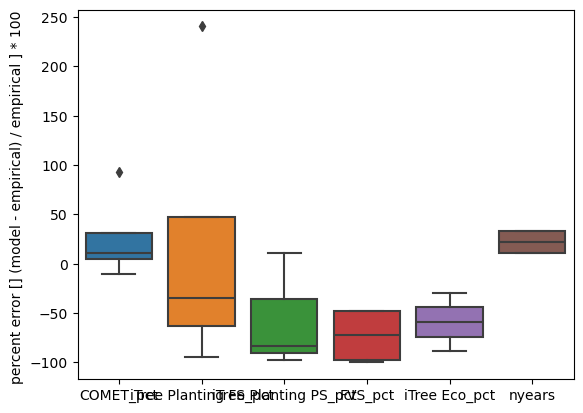

In [6]:
import matplotlib.pyplot as plt

ax = sns.boxplot(data=rdf_pct)
ax.set_ylabel('percent error [] (model - empirical) / empirical ] * 100 ')
plt.show()

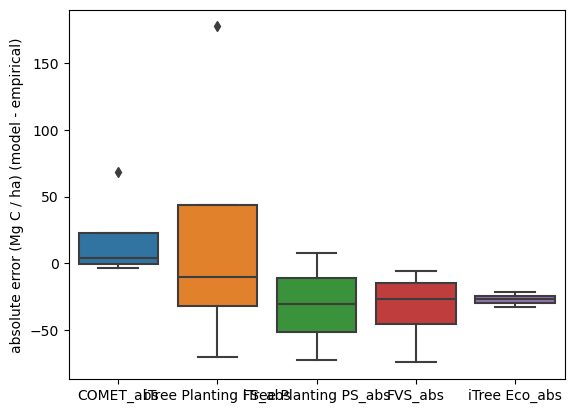

In [7]:
ax = sns.boxplot(data=rdf_abs)
ax.set_ylabel('absolute error (Mg C / ha) (model - empirical)')
plt.show()

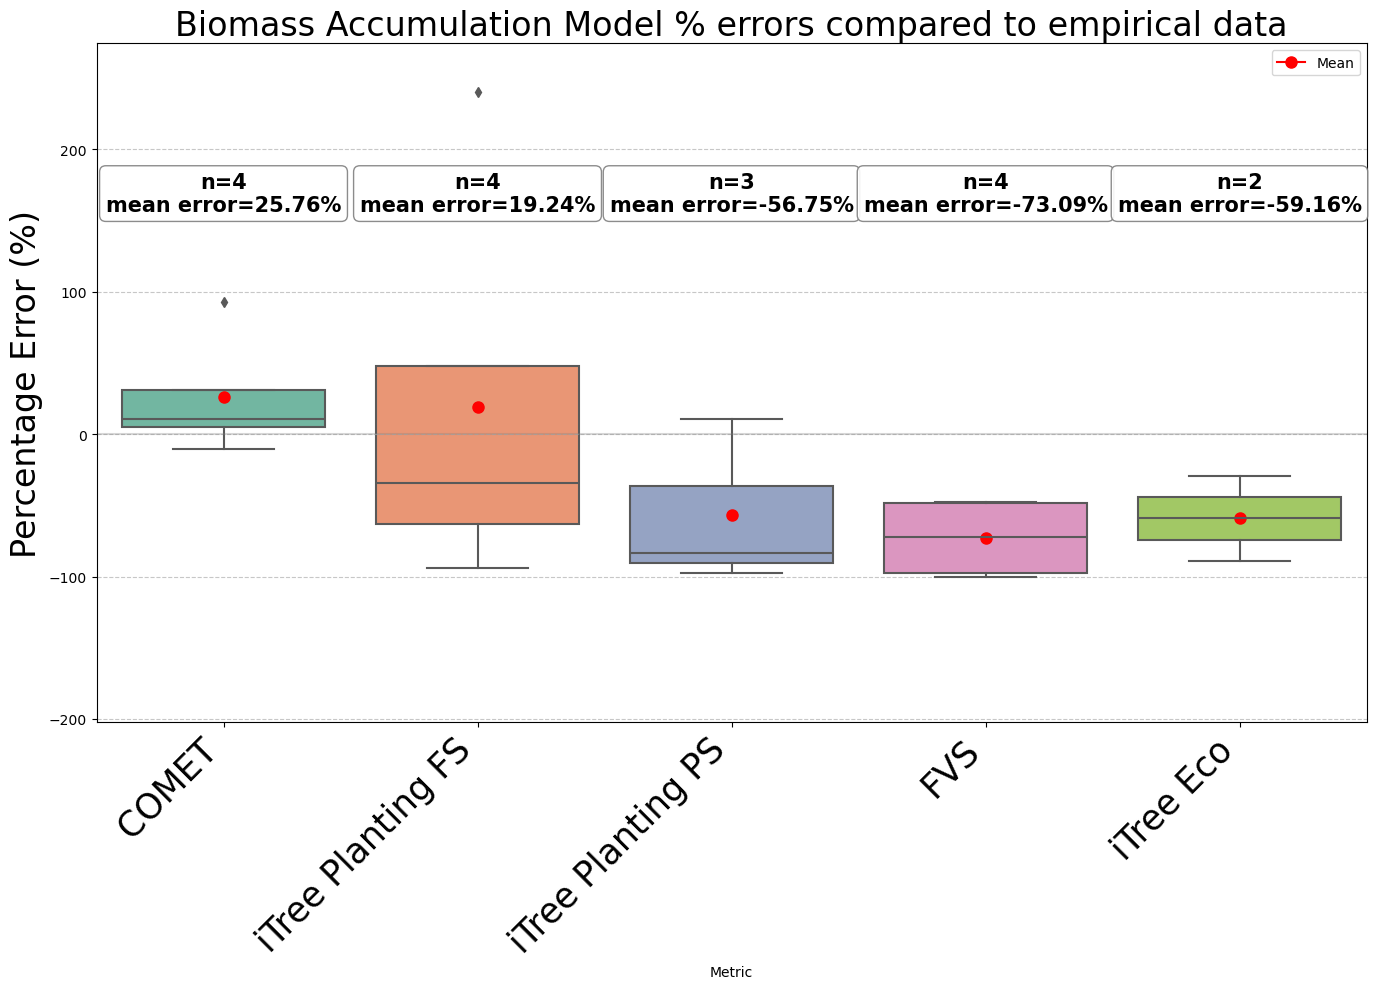

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Read the CSV file
df = pd.read_csv('../results/rdf_pct.csv')

# Drop the first column (index)
df = df.drop(df.columns[0], axis=1)

# rename columns 
mapping = {x:x.replace("_pct","") for x in list(df.columns)}
df.rename(columns = mapping, inplace = True)

# Remove the 'study' column for the boxplot (it's non-numeric)
plot_df = df.drop(['study','nyears'], axis=1)

# Calculate means, standard errors, and count non-NA values for each column
means = plot_df.mean()
std_errs = plot_df.sem()  # Standard Error of the Mean
n_obs = plot_df.count()   # Count non-NA values per column

# Prepare data for plotting in long format
plot_data = plot_df.melt(var_name='Metric', value_name='Percentage')

# Find the global min and max for better y-axis limits
global_min = plot_data['Percentage'].min()
global_max = plot_data['Percentage'].max()
data_range = global_max - global_min

# Create a figure with a larger size
plt.figure(figsize=(14, 10))  # Increased height to accommodate labels

# Create the boxplot
ax = sns.boxplot(x='Metric', y='Percentage', data=plot_data, palette="Set2")

# Add mean points on the boxplot
for i, col in enumerate(plot_df.columns):
    ax.plot(i, means[col], marker='o', color='red', markersize=8, label='Mean' if i == 0 else "")

# Set y-axis limits with extra padding
padding = data_range * 0.3  # Increased padding for labels
plt.ylim(global_min - padding, global_max + data_range * 0.1)

# Create small annotation boxes inside the plot area
for i, col in enumerate(plot_df.columns):
    # Get column data without NAs
    col_data = plot_df[col].dropna()
    
    # Skip if no data
    if len(col_data) == 0:
        continue
    
    # Calculate position for stats box - position in the lower part of the plot
    # but inside the plot boundaries
    stats_y_pos = global_max - padding * 0.7  # Position within the padding area
    
    # Create a more compact format for the stats box
    stats_text = f'''n={n_obs[col]}
mean error={means[col]:.2f}%'''
    
    # Add the text with a more compact box
    ax.text(i, stats_y_pos, stats_text, 
            ha='center', va='center', fontsize=15, fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', 
                     boxstyle='round,pad=0.3', linewidth=1))

# Set labels and title
plt.ylabel('Percentage Error (%)', fontsize=24)
plt.title('Biomass Accumulation Model % errors compared to empirical data', fontsize=24)

# Add a legend for the mean point
plt.legend(loc='upper right')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=25)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a subtle horizontal line at y=0 for reference
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()